In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, precision_recall_curve, roc_auc_score, \
    confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv("../data/df_processed.csv")
df

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,gene_id,label
0,ENST00000000233,0.012869,AAGACCA,0.011239,0.009548,0.649123,0.117647,0.050283,0.578164,0.075390,0.058543,0.281707,ENSG00000004059,0.0
1,ENST00000000233,0.012869,AAGACCA,0.039294,0.011831,0.649123,0.049729,0.022461,0.627792,0.085258,0.033525,0.242683,ENSG00000004059,0.0
2,ENST00000000233,0.012869,AAGACCA,0.025266,0.018581,0.448622,0.087575,0.058051,0.602978,0.032761,0.010845,0.226829,ENSG00000004059,0.0
3,ENST00000000233,0.012869,AAGACCA,0.019605,0.009548,0.649123,0.048702,0.024112,0.677419,0.032761,0.019819,0.236585,ENSG00000004059,0.0
4,ENST00000000233,0.012869,AAGACCA,0.042082,0.013725,0.586466,0.007335,0.018917,0.665012,0.111901,0.038148,0.258537,ENSG00000004059,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11026929,ENST00000641834,0.090244,TTGACAT,0.021295,0.035919,0.436090,0.029192,0.049312,0.503722,0.082297,0.010192,0.187805,ENSG00000167747,0.0
11026930,ENST00000641834,0.090244,TTGACAT,0.042082,0.008820,0.448622,0.031685,0.059508,0.429280,0.157292,0.013456,0.165854,ENSG00000167747,0.0
11026931,ENST00000641834,0.090244,TTGACAT,0.046899,0.021787,0.398496,0.017016,0.031735,0.466501,0.014802,0.011661,0.296341,ENSG00000167747,0.0
11026932,ENST00000641834,0.090244,TTGACAT,0.008450,0.010859,0.448622,0.054789,0.050283,0.404467,0.049142,0.023409,0.192683,ENSG00000167747,0.0


<AxesSubplot:xlabel='label', ylabel='count'>

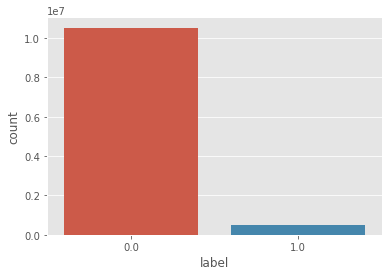

In [3]:
sns.countplot(x=df['label'])

In [4]:
X = df[['0', '1', '2', '3', '4', '5', '6', '7', '8']]
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
Counter(y_train)

Counter({0.0: 8422019, 1.0: 399528})

# Smote

In [12]:
sm = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [13]:
Counter(y_train_smote)

Counter({0.0: 8422019, 1.0: 4211009})

# Smote + ENN

In [9]:
# smenn = SMOTEENN(n_jobs=-1, random_state=42)
# X_train_smoteenn, y_train_smoteenn = smenn.fit_resample(X_train, y_train)

# Logistic Regression

In [14]:
log_model = LogisticRegression()
log_model.fit(X_train_smote, y_train_smote)

y_pred = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
y_pred_prob

array([0.19885834, 0.3411456 , 0.44832932, ..., 0.25433059, 0.56317926,
       0.48899436])

ROC AUC = 0.682
F1 = 0.126


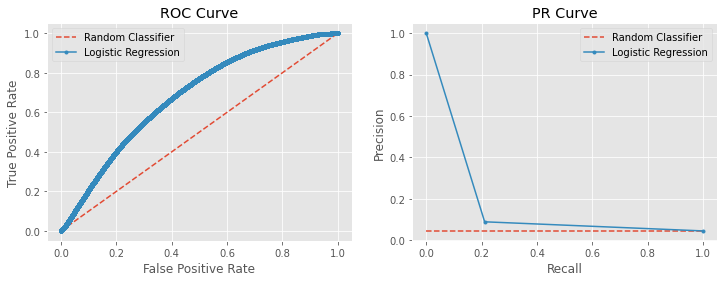

In [15]:
# evaluate predictions
roc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC = {roc:.3f}')
f1score = f1_score(y_test, y_pred)
print(f'F1 = {f1score:.3f}')


# create random classifier
rc_prob = [0 for _ in range(len(y_test))]

# roc curves
rc_fpr, rc_tpr, _ = roc_curve(y_test, rc_prob)
y_fpr, y_tpr, _ = roc_curve(y_test, y_pred_prob)

# pr curves
rc_precision, rc_recall, _ = precision_recall_curve(y_test, rc_prob)
y_precision, y_recall, _ = precision_recall_curve(y_test, y_pred)

# plot the roc curve for the model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rc_fpr, rc_tpr, linestyle='--', label='Random Classifier')
plt.plot(y_fpr, y_tpr, marker='.', label='Logistic Regression')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 2, 2)
random_classifier = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [random_classifier, random_classifier], linestyle='--', label='Random Classifier')
plt.plot(y_recall, y_precision, marker='.', label='Logistic Regression')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show the plot
plt.show()